# Useful Functions

In [1]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = mean_squared_error(test, predictions, squared = False)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

In [2]:
# Function to plot the future
def plot_future(y, forecast, title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train and forecast data
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

# Libraries and Data

In [69]:
# from google.colab import drive
# drive.mount('/content/drive')

In [70]:
# %cd /content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/ARIMA, SARIMA and SARIMAX

In [3]:
!pip install pmdarima

In [4]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima, ARIMA, model_selection
import numpy as np
from sklearn.model_selection import ParameterGrid

In [5]:
# Loading the daily revenue data and set the date as uindex
df = pd.read_csv("Amazon.csv",
                 index_col = "Date",
                 parse_dates = True,
                 dayfirst = True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [6]:
df.shape

(5842, 6)

In [7]:
# Information about the df
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5842 entries, 1997-05-15 to 2020-07-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5842 non-null   float64
 1   High       5842 non-null   float64
 2   Low        5842 non-null   float64
 3   Close      5842 non-null   float64
 4   Adj Close  5842 non-null   float64
 5   Volume     5842 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 319.5 KB


There is no preprocessing that can happen here because the data is of type float and int

In [74]:
# Remove the comma in revenue and convert it as float
df['revenue'] = df['revenue'].str.replace(",", "").astype(float)

In [8]:
# Set the dataframe to have daily frequency, it will give a lot of null value
df_freq_d = df.asfreq("D")

We will consider the close as y value

In [9]:
# Change the time Series variable name
df_freq_d = df_freq_d.rename(columns = {'Close': 'y'})
df_freq_d.head()

,Open,High,Low,y,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000.0
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000.0
1997-05-17,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-18,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0


In [11]:
df_freq_d.shape

(8479, 6)

Here after using the frequency of Day, it was having many NaN values because of the weekends days [Saturday, Sunday] and we find that the shape has increased from 5842 to 8479, so we will use the B day instead

In [13]:
df_freq_B = df.asfreq("B")

In [14]:
df_freq_B.shape

(6057, 6)

In [15]:
df_freq_B.isnull().sum()

Open         215
High         215
Low          215
Close        215
Adj Close    215
Volume       215
dtype: int64

In [16]:
df_freq_B.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000.0
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000.0
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200.0
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200.0


The reason the size became 6057 and not 5842 was because many business days could be off due to official holidays and/or extraordinary event

In [17]:
# Here we see which days were added and at the same time were holiday and/or extraordinary event
df_original = pd.read_csv("Amazon.csv", index_col="Date", parse_dates=True, dayfirst=True)
df_full = df_original.asfreq("B")

missing_dates = df_full[df_full['Open'].isna()].index
print(missing_dates)
print(len(missing_dates))

DatetimeIndex(['1997-05-26', '1997-07-04', '1997-09-01', '1997-11-27',
               '1997-12-25', '1998-01-01', '1998-01-19', '1998-02-16',
               '1998-04-10', '1998-05-25',
               ...
               '2019-07-04', '2019-09-02', '2019-11-28', '2019-12-25',
               '2020-01-01', '2020-01-20', '2020-02-17', '2020-04-10',
               '2020-05-25', '2020-07-03'],
              dtype='datetime64[ns]', name='Date', length=215, freq=None)
215


A list of commonly used `.asfreq()` aliases:

Time-based frequencies:

- 'D': Calendar day frequency
- 'B': Business day frequency
- 'W': Weekly frequency
- 'W-MON', 'W-TUE', ..., 'W-SUN': Weekly frequency (anchored on a specific day)
- 'M': Month end frequency
- 'MS': Month start frequency
- 'Q': Quarter end frequency
- 'QS': Quarter start frequency
- 'A' or 'Y': Year end frequency
- 'BA' or 'BY': Business year end frequency
- 'AS' or 'YS': Year start frequency
- 'BAS' or 'BYS': Business year start frequency


Hourly, minutely, and secondly frequencies:

- 'H': Hourly frequency
- 'T' or 'min': Minutely frequency
- 'S': Secondly frequency


You can also use multiples, like:

- '2D': Every 2 days
- '4H': Every 4 hours
- '15T' or '15min': Every 15 minutes

# Exploratory Data Analysis

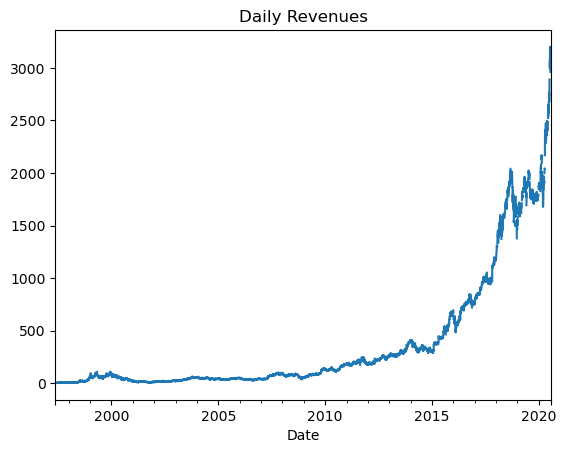

In [19]:
# Daily revenues line plot
df_freq_d['y'].plot(title = 'Daily Revenues')
plt.show()

In [20]:
df_freq_d.head()

,Open,High,Low,y,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000.0
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000.0
1997-05-17,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-18,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0


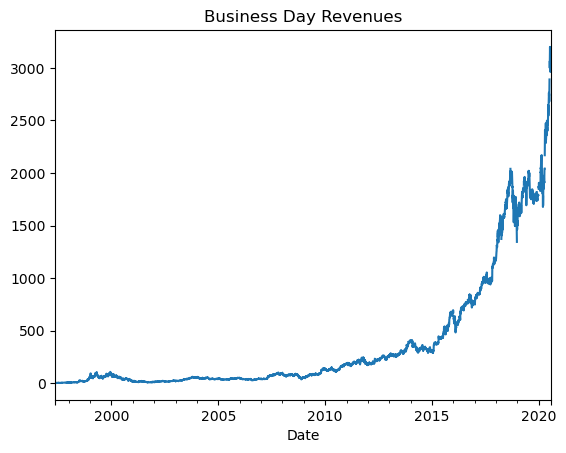

In [22]:
df_freq_B = df_freq_B.rename(columns = {'Close': 'y'})
df_freq_B['y'].plot(title = 'Business Day Revenues')
plt.show()

In [23]:
df_freq_B.head()

,Open,High,Low,y,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000.0
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000.0
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200.0
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200.0


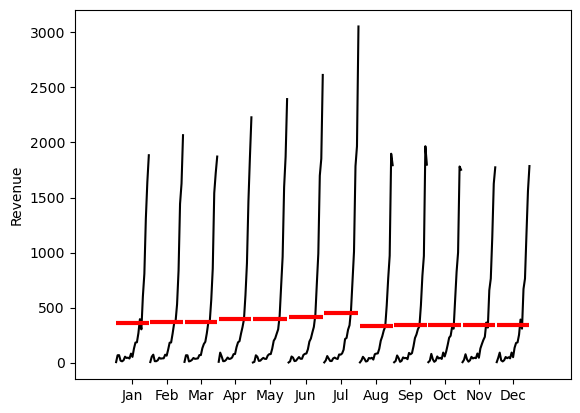

In [24]:
# month_plot() - To visualize the average value for each month across multiple years in a time series
# red lines - Represents the mean value for each month

# Plotting the monthly seasonality of revenue values
month_plot(df_freq_d['y'].resample('M').mean(),
           ylabel = 'Revenue')
plt.show()

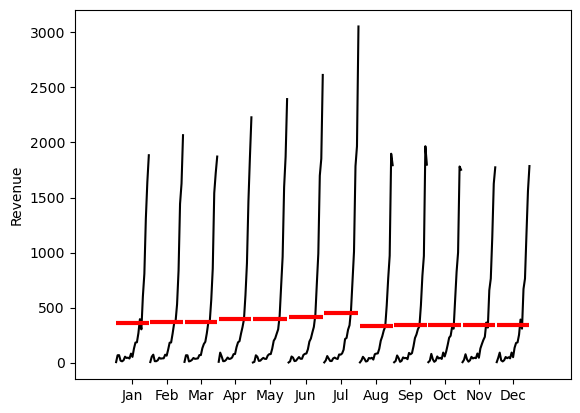

In [25]:
month_plot(df_freq_B['y'].resample('M').mean(),
           ylabel = 'Revenue')
plt.show()

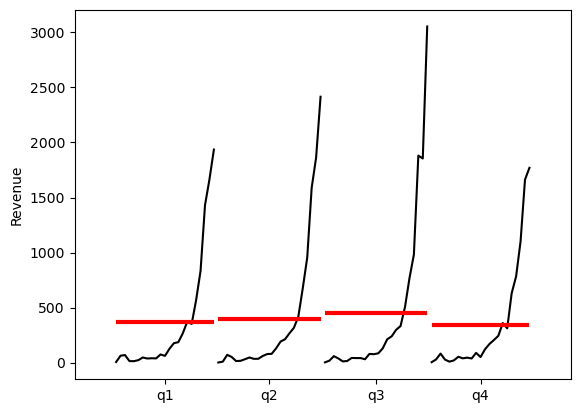

In [26]:
# quarter_plot() - To visualize seasonal patterns at a quarterly level.
# Q1 (january, february, march), Q2 (april, may, june), Q3 (july, august, september), Q4 (october, november, december)

# Plotting the quarterly seasonality of revenue values
# .resample('Q') - to convert the time series data into quarterly seasonality
quarter_plot(df_freq_d['y'].resample('Q').mean(),
           ylabel = 'Revenue')
plt.show()

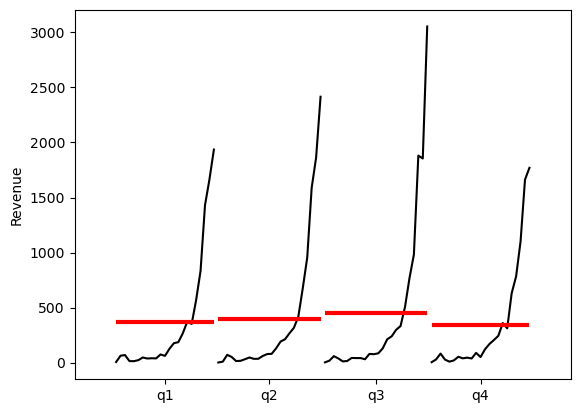

In [27]:
quarter_plot(df_freq_B['y'].resample('Q').mean(),
           ylabel = 'Revenue')
plt.show()

We can see there is no clear difference between the two, the reason any null values are automatically being ignored so we will use the buisness from now on

`seasonal_decompose` - To decompose a time series into its constituent parts to better understand the underlying patterns.

components

- Trend: The overall direction of the series (increasing, decreasing, or stable).
- Seasonal: Repeating patterns at fixed intervals (e.g., daily, weekly, monthly).
- Residual: The remaining variation after removing trend and seasonal components.

In [28]:
# Seasonal Decomposition Plots for Revenue Data
# Multiplicative model type, with daily seasonality (365 days)
df = df
decomposition = seasonal_decompose(df['y'],
                                   model = 'mul',
                                   period = 365)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

ValueError: This function does not handle missing values

Autocorrelation measures the correlation between a time series and a lagged version of itself.

Purpose: To identify patterns or repeating cycles in a time series dataset.

Interpretation:
- Values range from -1 to 1.
- 1 indicates perfect positive correlation.
- -1 indicates perfect negative correlation.
- 0 indicates no correlation.

ACF Plot:
- X-axis: Lag periods
- Y-axis: Correlation coefficient

Key Features:
- At lag 0, autocorrelation is always 1 (a series is perfectly correlated with itself).
- Significant spikes at certain lags indicate repeating patterns.


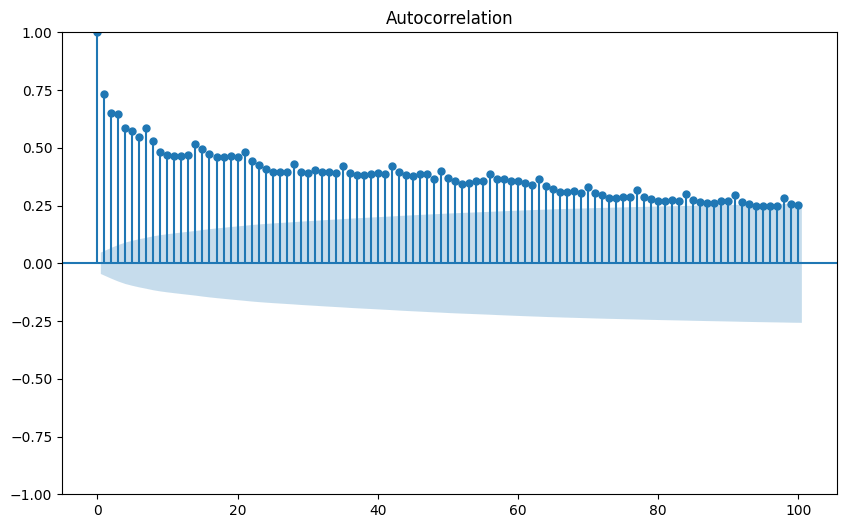

In [82]:
# Plot the autocorrelation (ACF) of revenue values
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['y'], lags = 100, ax = ax)
plt.show()

PACF measures the correlation between a time series and its lag, after removing the effects of all shorter lags.

Purpose: To identify the direct relationship between an observation and its lag, without intermediate effects.

Main Difference between ACF and PACF:
- ACF: Measures overall correlation at each lag, including indirect effects.
- PACF: Measures direct correlation at each lag, excluding indirect effects.

C:\Users\Breadfast\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


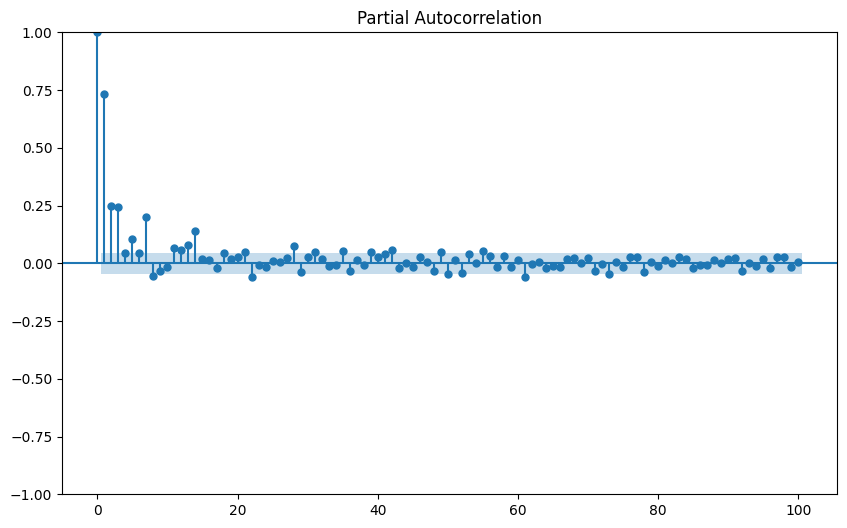

In [83]:
# Plot the partial autocorrelation (PACF) of revenue values
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['y'], lags = 100, ax = ax)
plt.show()

`.resample()` offset aliases:
- B = business day
- D = calendar day
- W = weekly
- M = month end
- BM = business month end
- MS = month start
- BMS = business month start
- Q = quarter end
- BQ = business quarter end
- QS = quarter start
- BQS = business quarter start
- A = year end
- BA = business year end
- AS = year start
- BAS = business year start
- h = hourly
- min = minutely
- s = secondly
- ms = milliseconds
- us = microseconds

# Stationarity

`adfuller` - used to perform the Augmented Dickey-Fuller test, which is a statistical test for testing the stationarity of a time series

 Stationarity implies that the statistical properties of the time series, such as mean and variance, do not change over time.

 The test evaluates a null hypothesis that the time series is non-stationary. If the p-value obtained from the test is less than a significance level (commonly 0.05), we reject the null hypothesis and conclude that the time series is stationary.

In [84]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
# 'result' contains the test statistic and the p-value.
result = adfuller(df.y)
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")


p-value: 0.101904
Evidence suggests that the time series is not stationary.


In [85]:
# Compute the first difference of the 'y' column in DataFrame 'df' and assign it to a new column 'y_diff'.
# '.diff()' calculates the difference between consecutive elements along the specified axis (by default axis 0).
# 'dropna()' removes any rows with NaN values resulting from differencing.
df['y_diff'] = df.y.diff().dropna()
df['y_diff']

date
2018-01-01           NaN
2018-01-02     2651237.0
2018-01-03     -475975.0
2018-01-04     -660303.0
2018-01-05    -1410495.0
                 ...    
2022-11-26   -39180777.0
2022-11-27     4955921.0
2022-11-28      210050.0
2022-11-29   -17786305.0
2022-11-30      712049.0
Freq: D, Name: y_diff, Length: 1795, dtype: float64

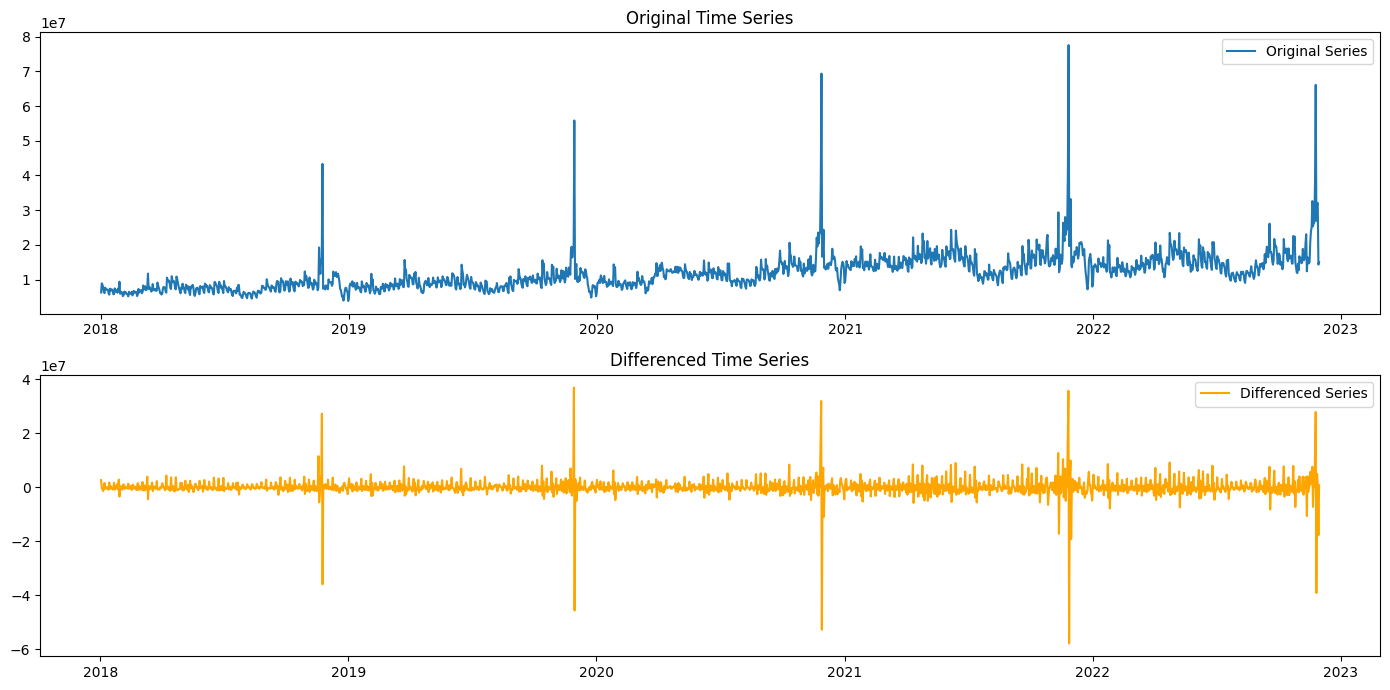

In [86]:
# Plotting the original and differenced series
# Set the size of the plot to 14 inches by 7 inches
plt.figure(figsize=(14, 7))

# Subplot for the original series
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(df.y, label='Original Series')
plt.title('Original Time Series')
plt.legend()

# Subplot for the differenced series
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(df['y_diff'], label='Differenced Series', color='orange')
plt.title('Differenced Time Series')
plt.legend()

# Adjust layout to prevent overlapping of titles and labels
plt.tight_layout()
plt.show()

In [ ]:
# Perform ADF test without null values
# 'result' contains the test statistic and the p-value.
result = adfuller(df['y_diff'].dropna())
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")


    

p-value: 0.000000
Evidence suggests that the time series is stationary.


# ARIMA Model

In [88]:
# Split the Data into training and test
test_days = 30 # Number of days to reserve for testing
train, test = df.iloc[:-test_days], df.iloc[-test_days:]
test

,y,discount_rate,coupon_rate,y_diff
date,,,,
2022-11-01,16703680.0,23.85%,1.50%,4014654.0
2022-11-02,15827022.0,20.76%,0.94%,-876658.0
2022-11-03,16154319.0,21.85%,0.92%,327297.0
2022-11-04,14707212.0,20.17%,0.88%,-1447107.0
2022-11-05,14877530.0,17.85%,0.41%,170318.0
2022-11-06,18835528.0,16.40%,0.31%,3957998.0
2022-11-07,16094516.0,17.11%,0.30%,-2741012.0
2022-11-08,15589508.0,16.64%,0.29%,-505008.0
2022-11-09,16608320.0,18.72%,0.74%,1018812.0


In [61]:
# auto_arima() from pmdarima - used to automatically select the optimal parameters for an ARIMA model based on the provided time series data.
# 'seasonal=False' indicates that the model should not consider seasonal components.
model = auto_arima(train['y'],
                   seasonal = False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1765
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -28817.267
Date:                Fri, 23 May 2025   AIC                          57650.535
Time:                        14:45:10   BIC                          57694.337
Sample:                    01-01-2018   HQIC                         57666.720
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.120     -3.449      0.001      -0.649      -0.179
ar.L2          0.3017      0.053      5.671      0.000       0.197       0.406
ar.L3          0.1570      0.028      5.705      0.000       0.103       0.211
ar.L4          0.0679      0.029      2.365      0.018       0.012       0.124
ar.L5          0.0466      0.024      1.937      0.053      -0.001       0.094
ma.L1         -0.1598      0.118     -1.354      0.176      -0.391       0.071
ma.L2         -0.7423      0.108     -6.872      0.000      -0.954      -0.531
sigma2      9.084e+12   1.86e-14   4.88e+26      0.000    9.08e+12    9.08e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            580903.26
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             5.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+43. Standard errors may be unstable.
"""

In [62]:
# Use the fitted ARIMA model to forecast future values.
# set the number of periods to forecast to the length of 'test'
predictions_arima = model.predict(n_periods = len(test))
predictions_arima

2022-11-01    1.445299e+07
2022-11-02    1.474103e+07
2022-11-03    1.503283e+07
2022-11-04    1.527520e+07
2022-11-05    1.534078e+07
2022-11-06    1.553442e+07
2022-11-07    1.554542e+07
2022-11-08    1.563967e+07
2022-11-09    1.565016e+07
2022-11-10    1.569221e+07
2022-11-11    1.570256e+07
2022-11-12    1.571953e+07
2022-11-13    1.572734e+07
2022-11-14    1.573420e+07
2022-11-15    1.573904e+07
2022-11-16    1.574197e+07
2022-11-17    1.574462e+07
2022-11-18    1.574600e+07
2022-11-19    1.574734e+07
2022-11-20    1.574804e+07
2022-11-21    1.574869e+07
2022-11-22    1.574906e+07
2022-11-23    1.574937e+07
2022-11-24    1.574956e+07
2022-11-25    1.574971e+07
2022-11-26    1.574981e+07
2022-11-27    1.574988e+07
2022-11-28    1.574994e+07
2022-11-29    1.574997e+07
2022-11-30    1.575000e+07
Freq: D, dtype: float64

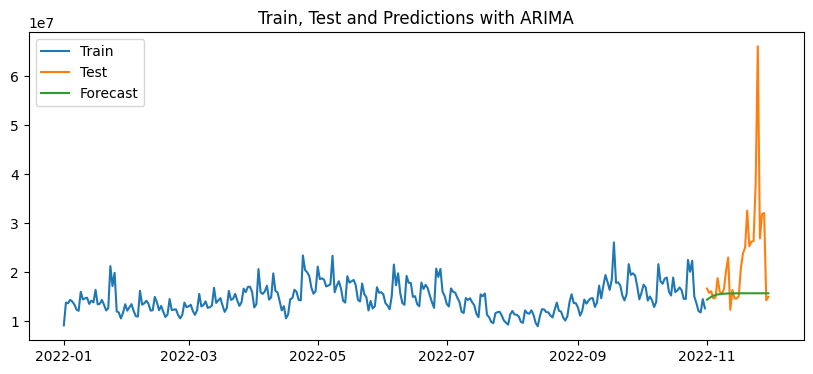

The MAE is 7267306.02
The RMSE is 12366038.30
The MAPE is 24.15 %


In [63]:
# Model assessment
model_assessment(train['y']['2022':], test['y'], predictions_arima, "ARIMA")

In [89]:
df.head()

,y,discount_rate,coupon_rate,y_diff
date,,,,
2018-01-01,6270839.0,34.27%,1.09%,NaN
2018-01-02,8922076.0,30.87%,1.08%,2651237.0
2018-01-03,8446101.0,28.11%,1.01%,-475975.0
2018-01-04,7785798.0,27.32%,0.96%,-660303.0
2018-01-05,6375303.0,25.70%,0.90%,-1410495.0


# SARIMA

In [64]:
# auto_arima() from pmdarima - used to automatically select the optimal parameters for an ARIMA model based on the provided time series data.
# m = The number of periods in each season.
model_sarima = auto_arima(train['y'],
                          m = 7)
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28762.051
Date:                           Fri, 23 May 2025   AIC                          57546.103
Time:                                   14:47:08   BIC                          57606.331
Sample:                               01-01-2018   HQIC                         57568.358
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.007e+04   4682.756      2.150      0.032     890.284    1.92e+04
ar.L1         -0.3476      0.072     -4.797      0.000      -0.490      -0.206
ar.L2          0.1856      0.032      5.722      0.000       0.122       0.249
ar.L3          0.1034      0.016      6.523      0.000       0.072       0.135
ma.L1         -0.1958      0.074     -2.656      0.008      -0.340      -0.051
ma.L2         -0.5684      0.060     -9.400      0.000      -0.687      -0.450
ar.S.L7        0.0805      0.181      0.445      0.656      -0.274       0.435
ar.S.L14       0.8713      0.172      5.071      0.000       0.534       1.208
ma.S.L7       -0.0035      0.176     -0.020      0.984      -0.349       0.342
ma.S.L14      -0.8322      0.157     -5.310      0.000      -1.139      -0.525
sigma2      9.294e+12      0.000   8.85e+16      0.000    9.29e+12    9.29e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            848655.96
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                             5.24
Prob(H) (two-sided):                  0.00   Kurtosis:                       109.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.91e+30. Standard errors may be unstable.
"""

In [25]:
# Use the fitted SARIMA model to forecast future values.
# set the number of periods to forecast to the length of 'test'
predictions_sarima = model_sarima.predict(n_periods = len(test))
predictions_sarima

2022-11-01    1.513411e+07
2022-11-02    1.504534e+07
2022-11-03    1.464457e+07
2022-11-04    1.382187e+07
2022-11-05    1.398001e+07
2022-11-06    1.697856e+07
2022-11-07    1.583308e+07
2022-11-08    1.605212e+07
2022-11-09    1.575798e+07
2022-11-10    1.523585e+07
2022-11-11    1.428027e+07
2022-11-12    1.448986e+07
2022-11-13    1.761291e+07
2022-11-14    1.658423e+07
2022-11-15    1.682759e+07
2022-11-16    1.635487e+07
2022-11-17    1.582120e+07
2022-11-18    1.482105e+07
2022-11-19    1.499263e+07
2022-11-20    1.780770e+07
2022-11-21    1.673572e+07
2022-11-22    1.694582e+07
2022-11-23    1.665826e+07
2022-11-24    1.616896e+07
2022-11-25    1.526418e+07
2022-11-26    1.547007e+07
2022-11-27    1.842691e+07
2022-11-28    1.745385e+07
2022-11-29    1.769225e+07
2022-11-30    1.726673e+07
Freq: D, dtype: float64

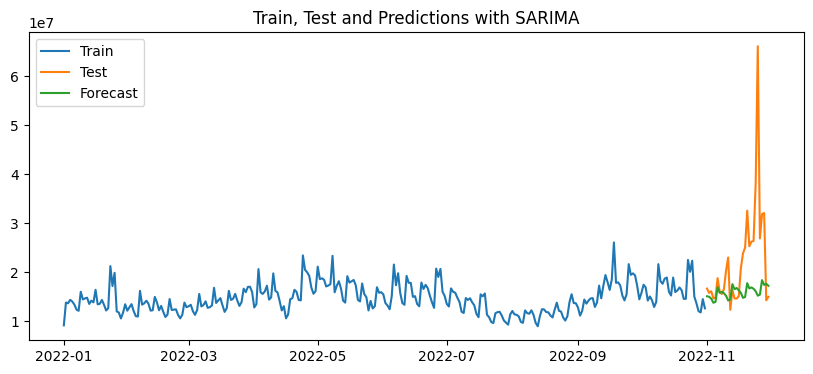

The MAE is 7210543.78
The RMSE is 12152386.18
The MAPE is 24.54 %


In [26]:
# Model assessment
model_assessment(train['y']['2022':], test['y'], predictions_sarima, "SARIMA")

* The MAE is 7267306.02
* The RMSE is 12366038.29
* The MAPE is 24.15 %

- `MAE` - the average of the absolute differences between predicted and actual values.
- `RMSE` - the square root of the average of squared differences between prediction and actual observation.
It gives a relatively high weight to large errors, making it sensitive to outliers.
- `MAPE` - the size of the error in percentage terms. the average of the absolute percent errors of forecasts, which helps to understand the accuracy in terms of percentage.

# SARIMAX

In [27]:
# Remove '%' symbol from 'discount_rate' and 'coupon_rate' column and convert to float
df['discount_rate'] = df['discount_rate'].str.replace("%", "").astype(float)
df['coupon_rate'] = df['coupon_rate'].str.replace("%", "").astype(float)

# Print the information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Freq: D
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   y              1795 non-null   float64
 1   discount_rate  1795 non-null   float64
 2   coupon_rate    1795 non-null   float64
 3   y_diff         1794 non-null   float64
dtypes: float64(4)
memory usage: 70.1 KB


In [28]:
# Split the Regressor Data into training and test
test_days = 30 # Number of days to reserve for testing
exog_train, exog_test = df.iloc[:-test_days,1:3], df.iloc[-test_days:,1:3]
exog_test.head()

,discount_rate,coupon_rate
date,,
2022-11-01,23.85,1.50
2022-11-02,20.76,0.94
2022-11-03,21.85,0.92
2022-11-04,20.17,0.88
2022-11-05,17.85,0.41


In [65]:
train['y']

date
2018-01-01     6270839.0
2018-01-02     8922076.0
2018-01-03     8446101.0
2018-01-04     7785798.0
2018-01-05     6375303.0
                 ...    
2022-10-27    13714667.0
2022-10-28    12100780.0
2022-10-29    11849363.0
2022-10-30    14561144.0
2022-10-31    12689026.0
Freq: D, Name: y, Length: 1765, dtype: float64

In [66]:
exog_train

,discount_rate,coupon_rate
date,,
2018-01-01,34.27,1.09
2018-01-02,30.87,1.08
2018-01-03,28.11,1.01
2018-01-04,27.32,0.96
2018-01-05,25.70,0.90
...,...,...
2022-10-27,20.81,0.61
2022-10-28,21.44,0.55
2022-10-29,19.81,0.36


In [ ]:
# auto_arima() from pmdarima - used to automatically select the optimal parameters for an ARIMA model based on the provided time series data.
# m = The number of periods in each season.
# X =  exogenous variables.
model_sarimax = auto_arima(train['y'],
                           m = 7,
                           X = exog_train
                           )
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28613.022
Date:                           Fri, 23 May 2025   AIC                          57250.045
Time:                                   04:44:26   BIC                          57315.749
Sample:                               01-01-2018   HQIC                         57274.324
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      1.641e+04   7882.494      2.082      0.037     961.315    3.19e+04
discount_rate   4.03e+05   2.35e+04     17.137      0.000    3.57e+05    4.49e+05
coupon_rate    9.229e+05    6.1e+04     15.134      0.000    8.03e+05    1.04e+06
ar.L1            -0.6527      0.156     -4.193      0.000      -0.958      -0.348
ar.L2             0.1827      0.049      3.763      0.000       0.088       0.278
ma.L1             0.1067      0.155      0.689      0.491      -0.197       0.410
ma.L2            -0.6922      0.124     -5.560      0.000      -0.936      -0.448
ar.S.L7           0.0525      0.187      0.280      0.779      -0.315       0.420
ar.S.L14          0.8998      0.178      5.059      0.000       0.551       1.248
ma.S.L7           0.0181      0.183      0.099      0.921      -0.340       0.376
ma.S.L14         -0.8500      0.161     -5.283      0.000      -1.165      -0.535
sigma2         7.655e+12      0.016   4.78e+14      0.000    7.65e+12    7.65e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           1075228.53
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                             5.53
Prob(H) (two-sided):                  0.00   Kurtosis:                       123.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+29. Standard errors may be unstable.
"""

AR --> y1(t)=0.5 * y(t-1) + 0.9 y(t-2)  + ....      --> 9

S --> y2(t) = 0.5 y(t-365) + 0.1 y(t - 365*2) - ......  --> +2
  
X --> y3(t) bla bla bla   --> +1

final y(t) = AR y(t) + S y(t) + X y(t) = 12





 --------    MA --> y(t) = 0.1 e(t-1) + 0.2 * e(t-2)  --> -1


 final final y(t) = final y(t) + MA y(t) = 12 - 1 = 11


In [30]:
# Use the fitted SARIMAX model to forecast future values.
# set the number of periods to forecast to the length of 'test'
# X - representing the exogenous variables for forecasting
predictions_sarimax = model_sarimax.predict(n_periods = len(test),
                                            X = exog_test)
predictions_sarimax

2022-11-01    1.675202e+07
2022-11-02    1.494541e+07
2022-11-03    1.488398e+07
2022-11-04    1.296372e+07
2022-11-05    1.205416e+07
2022-11-06    1.394966e+07
2022-11-07    1.341710e+07
2022-11-08    1.328236e+07
2022-11-09    1.441165e+07
2022-11-10    2.077573e+07
2022-11-11    2.121825e+07
2022-11-12    1.346294e+07
2022-11-13    1.489139e+07
2022-11-14    1.299947e+07
2022-11-15    1.348097e+07
2022-11-16    1.398062e+07
2022-11-17    1.803911e+07
2022-11-18    1.675100e+07
2022-11-19    1.712306e+07
2022-11-20    1.980822e+07
2022-11-21    1.847932e+07
2022-11-22    1.908257e+07
2022-11-23    1.913661e+07
2022-11-24    2.068937e+07
2022-11-25    1.926306e+07
2022-11-26    1.851280e+07
2022-11-27    2.073309e+07
2022-11-28    2.608046e+07
2022-11-29    1.588336e+07
2022-11-30    1.480008e+07
Freq: D, dtype: float64

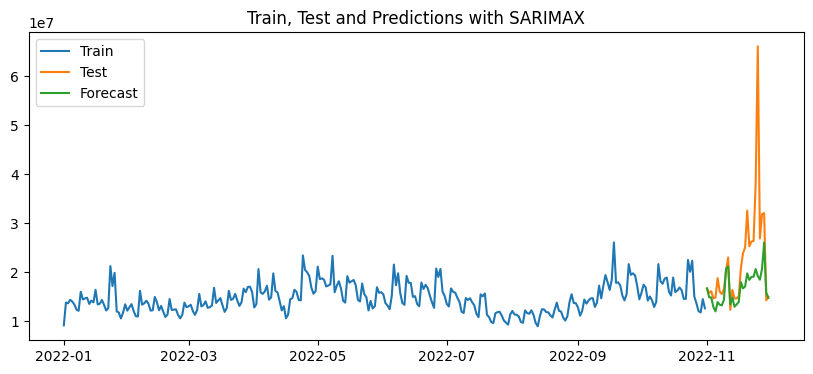

The MAE is 5716464.90
The RMSE is 10394494.40
The MAPE is 19.36 %


In [31]:
# Model assessment
model_assessment(train['y']['2022':], test['y'], predictions_sarimax, "SARIMAX")